In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA

In [96]:
# Load the dataset
df = pd.read_csv('./masked_kiva_loans.csv')
df.describe()

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count
count,3.356100e+04,33561.000000,33561.000000,32927.000000,33561.000000,33561.000000
mean,9.931834e+05,789.871279,843.059653,177.819145,13.691428,20.549179
std,1.965757e+05,1177.245363,1222.188679,93.838691,8.566574,28.514324
min,6.530490e+05,0.000000,25.000000,9.000000,1.000000,0.000000
25%,8.217790e+05,250.000000,275.000000,126.000000,8.000000,7.000000
50%,9.945450e+05,450.000000,500.000000,145.000000,13.000000,13.000000
75%,1.164156e+06,900.000000,975.000000,204.000000,14.000000,24.000000
max,1.340239e+06,50000.000000,50000.000000,533.000000,145.000000,1481.000000


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33561 entries, 0 to 33560
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  33561 non-null  int64  
 1   funded_amount       33561 non-null  int64  
 2   loan_amount         33561 non-null  int64  
 3   sector              33561 non-null  object 
 4   country             33561 non-null  object 
 5   partner_id          32927 non-null  float64
 6   term_in_months      33561 non-null  int64  
 7   lender_count        33561 non-null  int64  
 8   borrower_genders    33366 non-null  object 
 9   repayment_interval  33561 non-null  object 
 10  date                33561 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 2.8+ MB


In [98]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df['borrower_genders'] = df['borrower_genders'].apply(lambda x: x.split(', ')[0] if x else 'unknown')

In [99]:
#outlier function
def detect_outliers(df, column_name):
    # Extract the specified column as a pandas Series
    column_data = df[column_name]

    # Calculate summary statistics
    median_value = column_data.median()
    q1 = column_data.quantile(0.25)
    q3 = column_data.quantile(0.75)
    iqr = q3 - q1

    # Calculate lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identify outliers
    outliers = column_data[(column_data < lower_bound) | (column_data > upper_bound)]

    # Replace outliers with the corresponding bounds
    column_data = column_data.clip(lower=lower_bound, upper=upper_bound)

    # Update the DataFrame with the modified column
    df[column_name] = column_data


detect_outliers(df,"funded_amount")
detect_outliers(df,"loan_amount")
detect_outliers(df,"lender_count")
detect_outliers(df,"term_in_months")

In [100]:
df['date'] = pd.to_datetime(df['date'])

# Set 'Month' column as index
df.set_index('date', inplace=True)

# Group the data by sector and calculate the total funded amount
sector_funding = df.groupby('sector')['funded_amount'].sum().reset_index()
print(sector_funding)

            sector  funded_amount
0      Agriculture        5727900
1             Arts         403900
2         Clothing        1231375
3     Construction         241025
4        Education        1268825
5    Entertainment          28525
6             Food        4314075
7           Health         373400
8          Housing         987625
9    Manufacturing         215525
10    Personal Use         672850
11          Retail        3598325
12        Services        1532050
13  Transportation         454500
14       Wholesale          30875


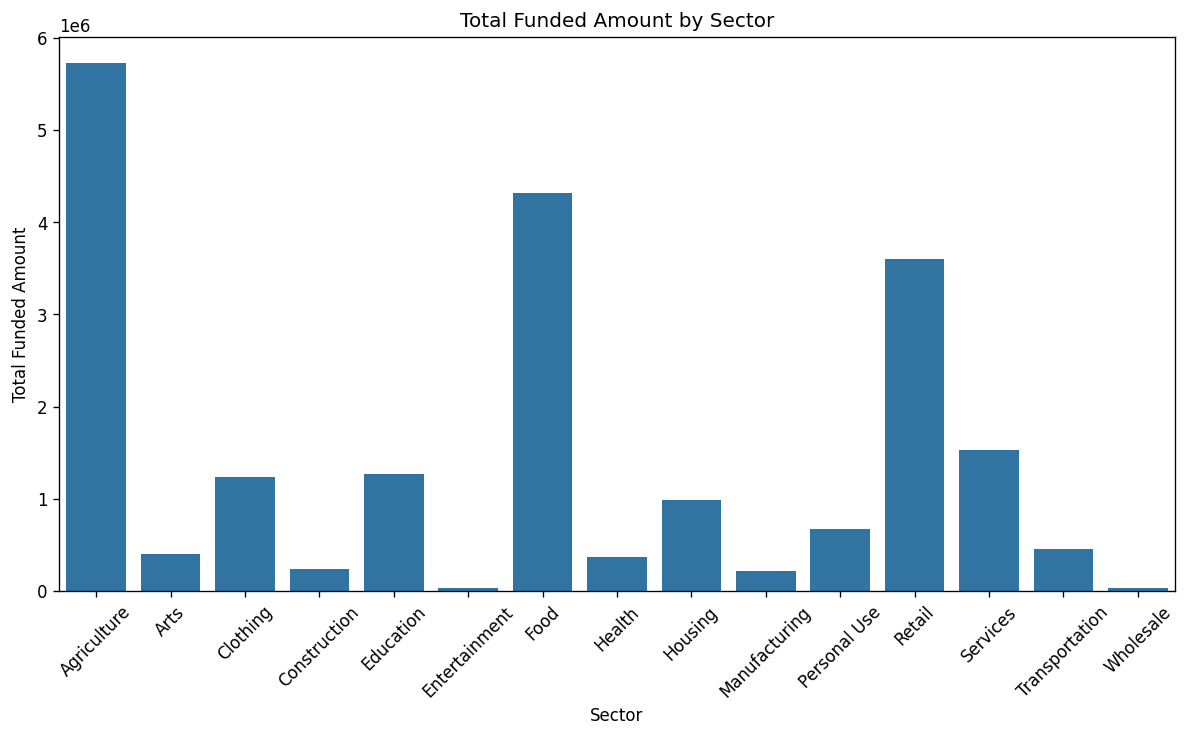

In [101]:
# Visualization: Total Funded Amount by Sector
plt.figure(figsize=(12, 6))
sns.barplot(x='sector', y='funded_amount', data=sector_funding)
plt.xticks(rotation=45)
plt.title('Total Funded Amount by Sector')
plt.xlabel('Sector')
plt.ylabel('Total Funded Amount')
plt.show()

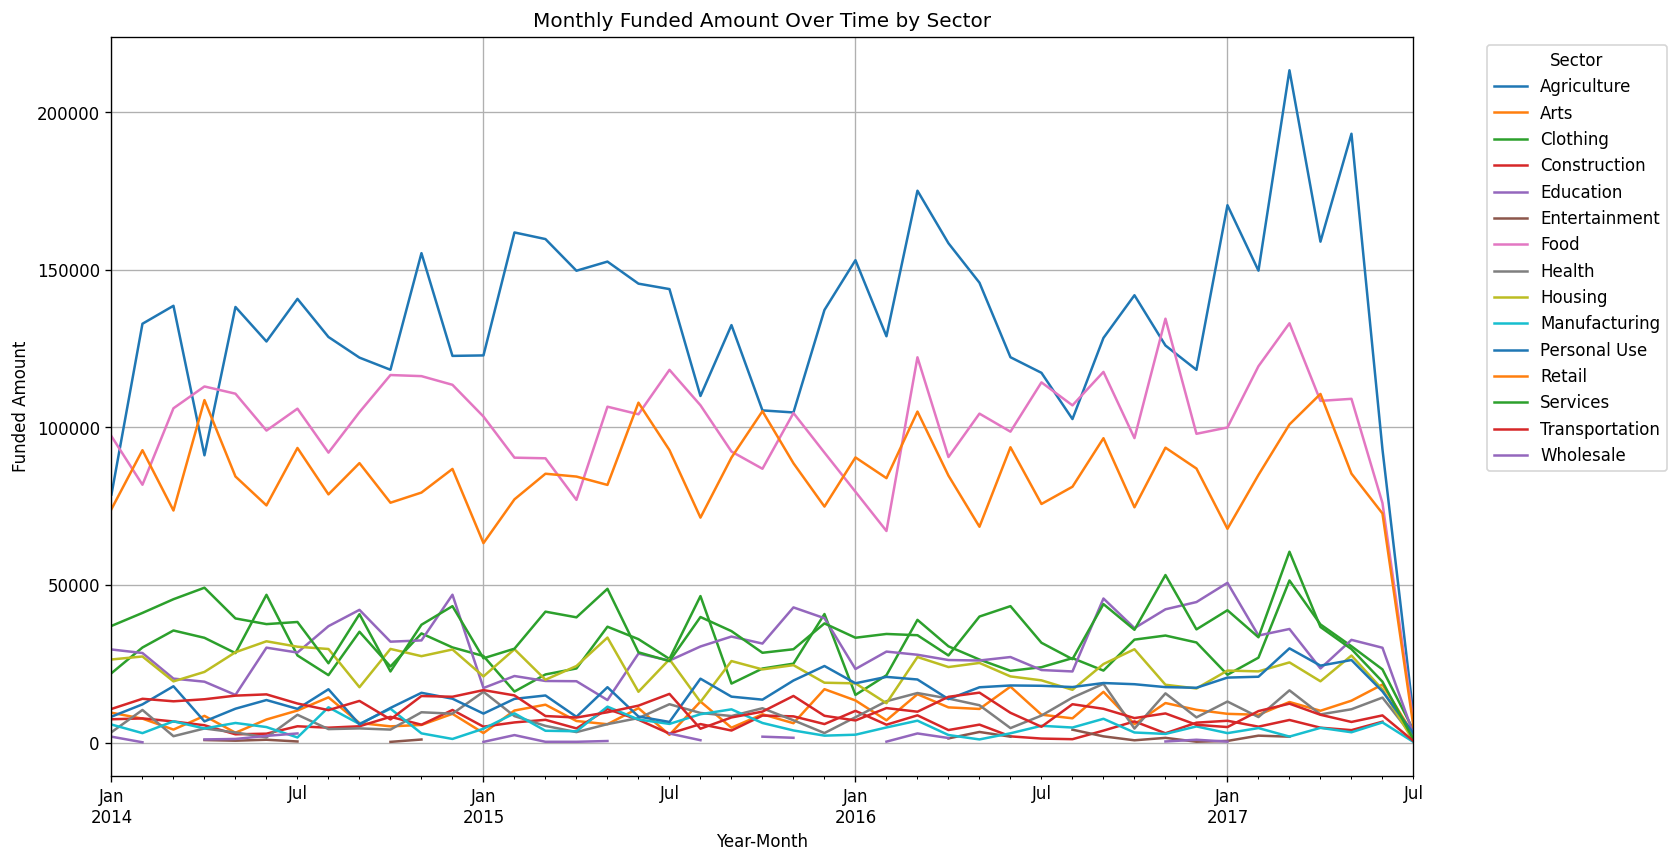

In [102]:
# Visualization: Funding Amount Over Time by Sector
df['year_month'] = df.index.to_period('M')
funding_by_sector_time = df.groupby(['year_month', 'sector'])['funded_amount'].sum().unstack()
funding_by_sector_time.plot(figsize=(14, 8))
plt.title('Monthly Funded Amount Over Time by Sector')
plt.xlabel('Year-Month')
plt.ylabel('Funded Amount')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [103]:
print(funding_by_sector_time)

sector      Agriculture     Arts  Clothing  Construction  Education  \
year_month                                                            
2014-01         78725.0   9475.0   22025.0        7400.0    29550.0   
2014-02        132925.0   7600.0   30175.0        7675.0    28425.0   
2014-03        138625.0   4125.0   35575.0        6700.0    20300.0   
2014-04         91175.0   8475.0   33250.0        5500.0    19325.0   
2014-05        138250.0   3125.0   28400.0        2625.0    15125.0   
2014-06        127300.0   7325.0   46900.0        2825.0    30125.0   
2014-07        140825.0  10175.0   27650.0        5175.0    28575.0   
2014-08        128725.0  14350.0   21400.0        4725.0    36950.0   
2014-09        122175.0   6225.0   35175.0        5175.0    42125.0   
2014-10        118325.0   5150.0   24150.0        8175.0    32025.0   
2014-11        155325.0   5600.0   34650.0        5675.0    32425.0   
2014-12        122725.0   9125.0   30200.0       10350.0    46925.0   
2015-0

In [104]:
correlation = df['lender_count'].corr(df['funded_amount'])
print("Correlation between lender count and funded amount:", correlation)

Correlation between lender count and funded amount: 0.8610715022152271


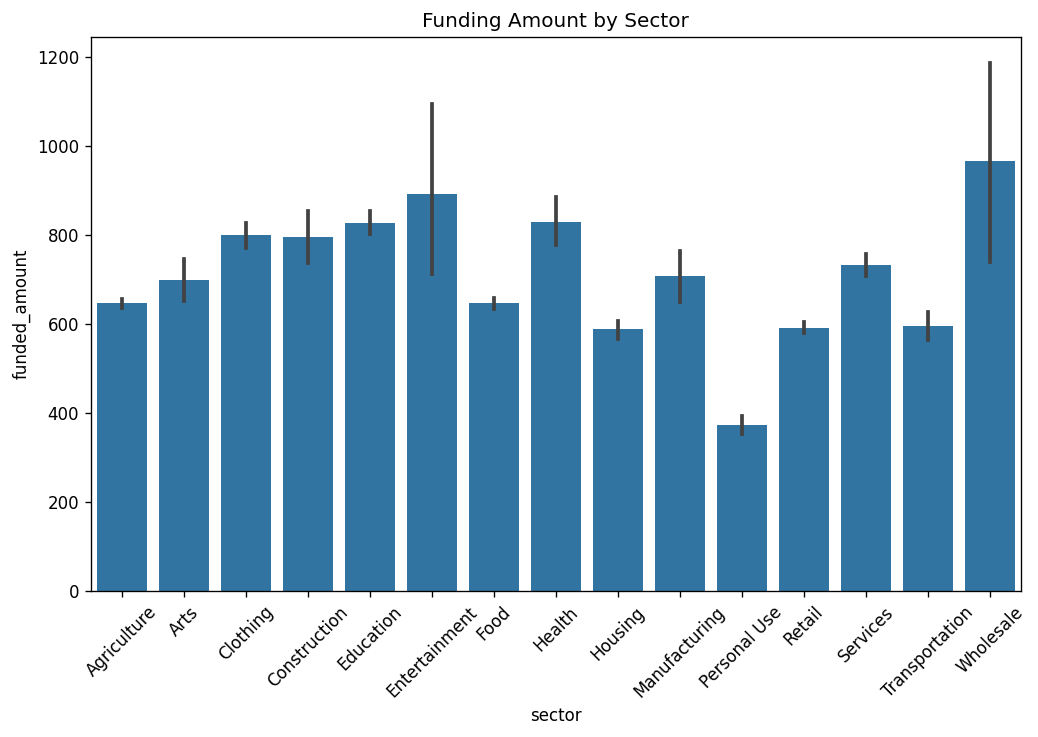

In [105]:
# Visualization Example: Funding by Sector
plt.figure(figsize=(10, 6))
sns.barplot(x='sector', y='funded_amount', data=df)
plt.xticks(rotation=45)
plt.title('Funding Amount by Sector')
plt.show()

In [106]:
# Calculate the correlation between lender count and funded amount
correlation = df['lender_count'].corr(df['funded_amount'])
print("Correlation between lender count and funded amount:", correlation)

Correlation between lender count and funded amount: 0.8610715022152271


In [107]:
# Machine Learning Model
x = df[['loan_amount', 'lender_count', 'term_in_months']]
y = df['funded_amount']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)
predictions = model.predict(x_test)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("Mean Squared Error:", mse)
print('RMSE:', np.sqrt(mse))
print('r2_score:', r2)

Mean Squared Error: 15632.984225643482
RMSE: 125.031932823753
r2_score: 0.9428876216718975


C:\Users\PC\AppData\Local\Temp\ipykernel_19000\3856741509.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  funded_amount_ts = df['funded_amount'].resample('M').sum()


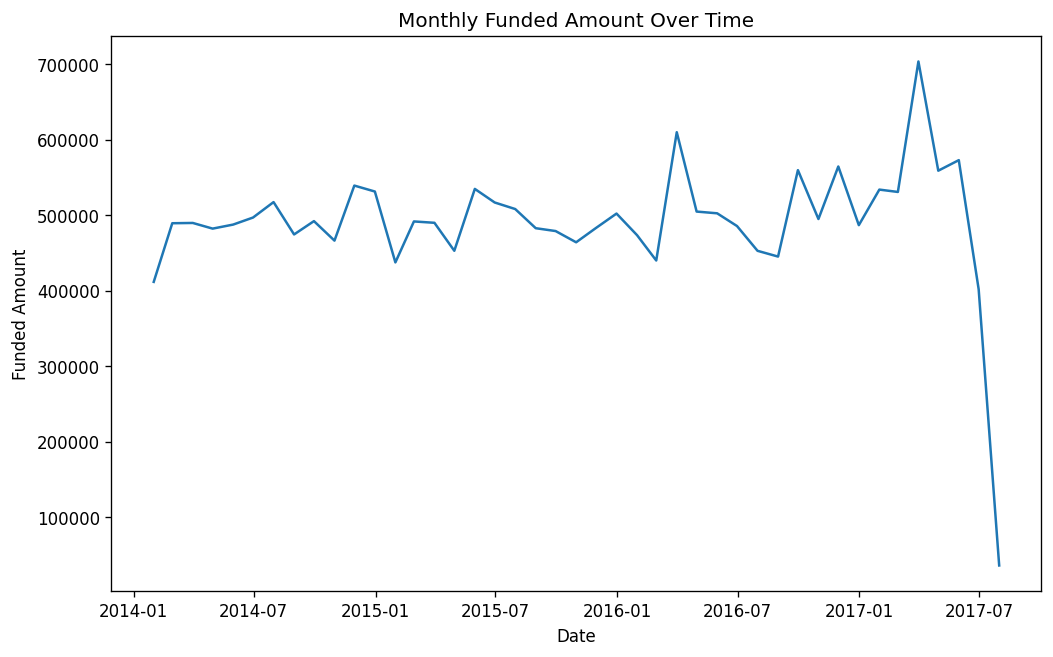

In [108]:
# Step 1: Visualize the time series
funded_amount_ts = df['funded_amount'].resample('M').sum()

plt.figure(figsize=(10, 6))
plt.plot(funded_amount_ts)
plt.title('Monthly Funded Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Funded Amount')
plt.show()



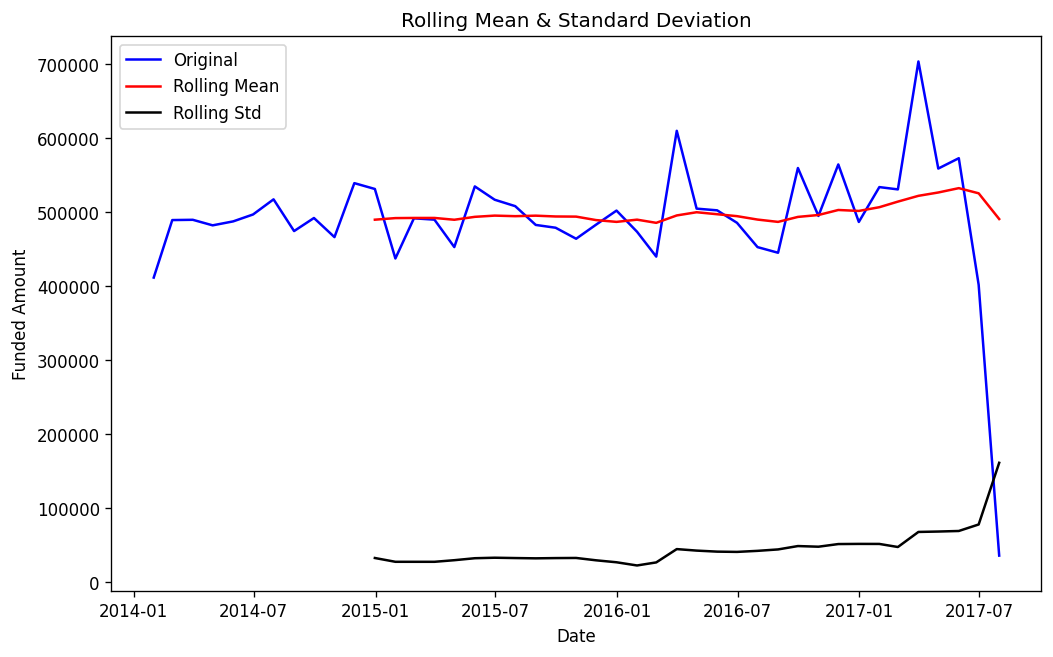

Results of Dickey-Fuller Test:
ADF Statistic: -3.652539068141864
p-value: 0.004832483399498428
Critical Values:
	1%: -3.639224104416853
	5%: -2.9512301791166293
	10%: -2.614446989619377


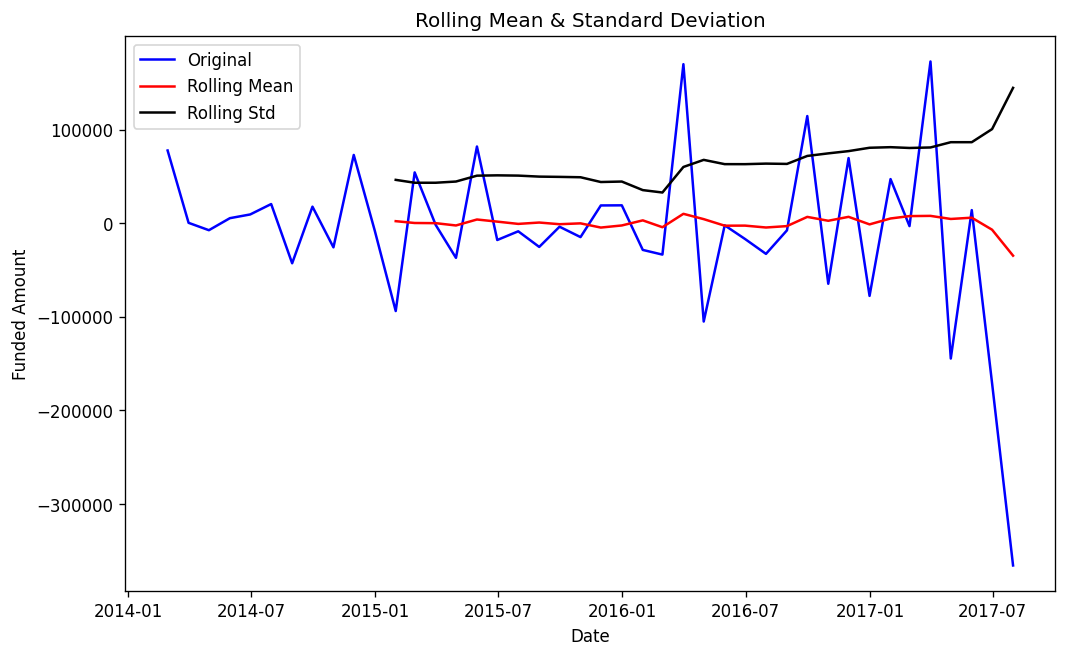

Results of Dickey-Fuller Test:
ADF Statistic: -4.351699855871736
p-value: 0.00036103568472687134
Critical Values:
	1%: -3.661428725118324
	5%: -2.960525341210433
	10%: -2.6193188033298647


In [109]:
# Step 2: Stationarize the series
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Date')
    plt.ylabel('Funded Amount')
    plt.legend(loc='best')
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    print('ADF Statistic:', dftest[0])
    print('p-value:', dftest[1])
    print('Critical Values:')
    for key, value in dftest[4].items():
        print('\t{}: {}'.format(key, value))

test_stationarity(funded_amount_ts)

# Differencing the series to make it stationary
funded_amount_ts_diff = funded_amount_ts.diff().dropna()
test_stationarity(funded_amount_ts_diff)

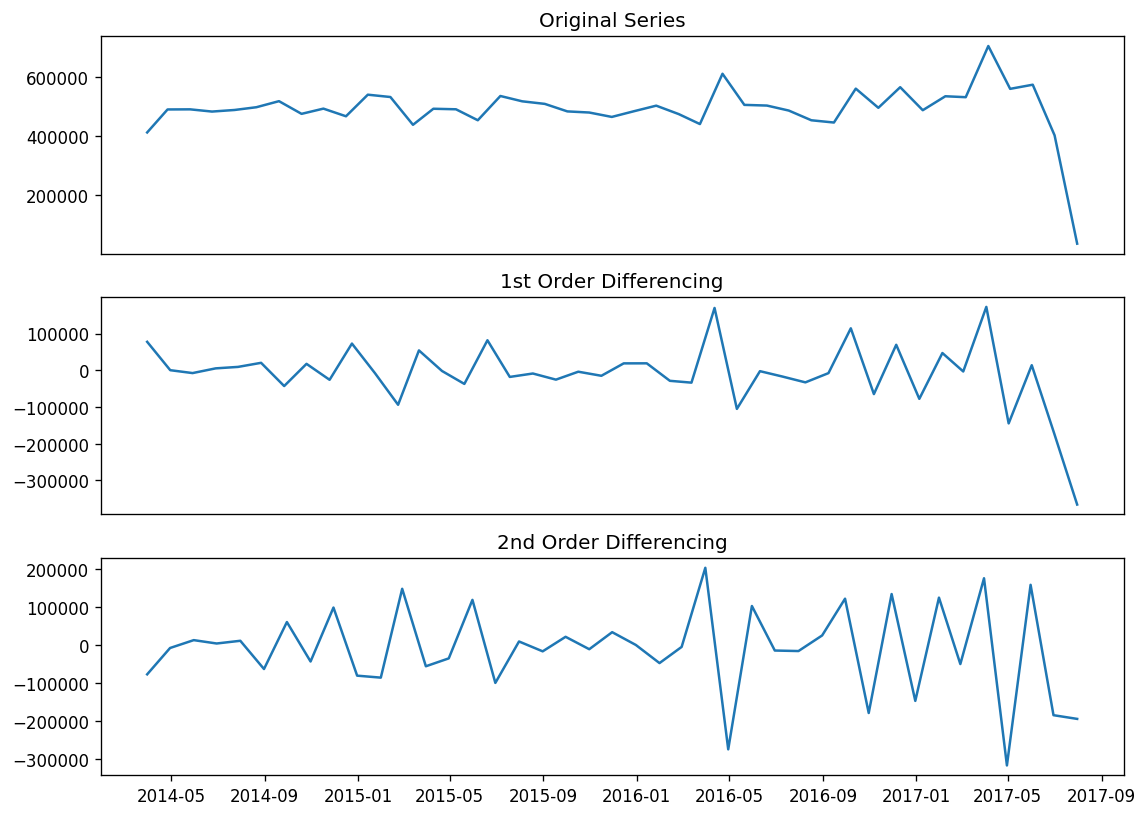

In [110]:
# Example usage:
# Visualize original series and its differences
plt.rcParams.update({'figure.figsize':(11,8), 'figure.dpi':120})

# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(funded_amount_ts); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(funded_amount_ts.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(funded_amount_ts.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

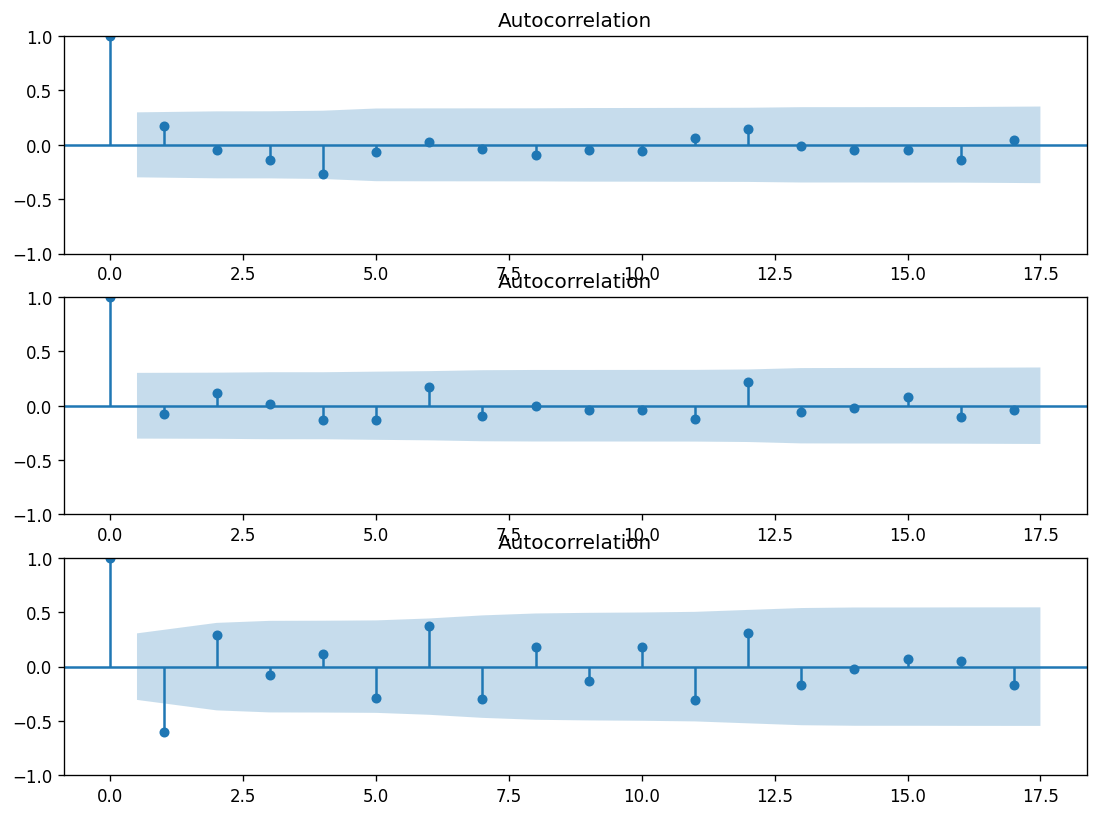

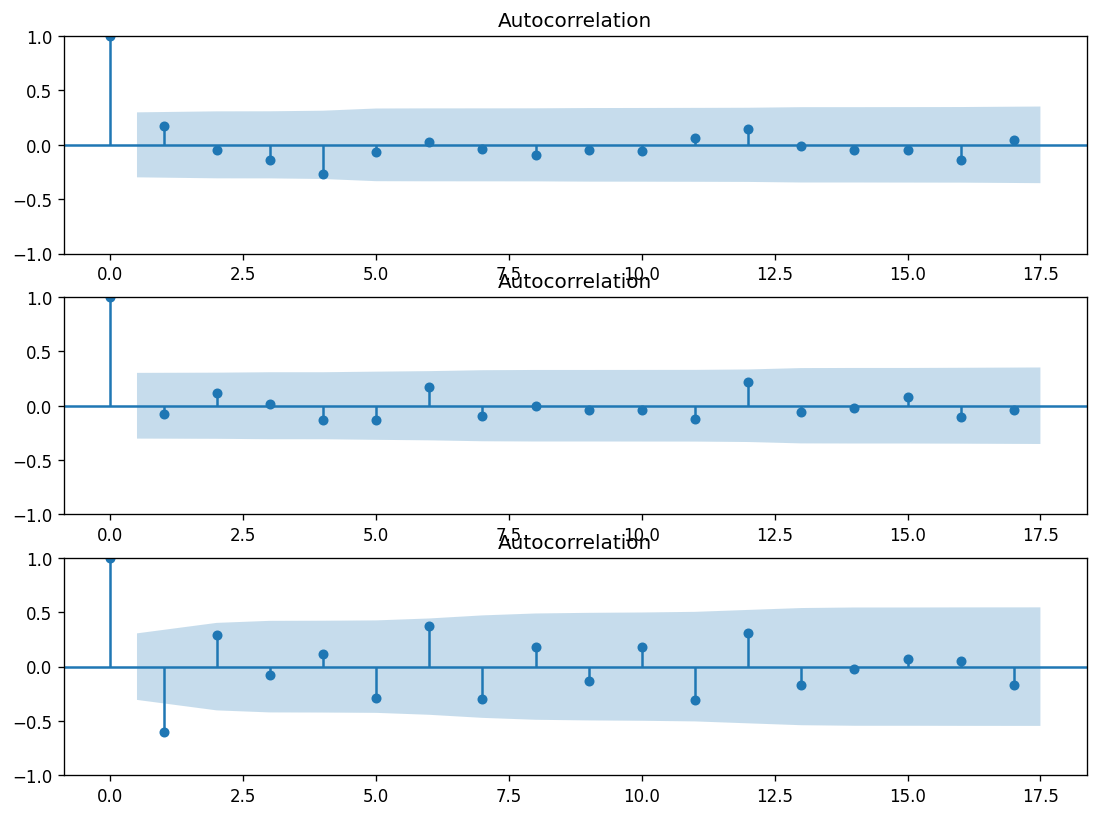

In [111]:
# Step 3: plot ACF & PACF
from statsmodels.graphics.tsaplots import plot_acf
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(funded_amount_ts, ax=ax1)
plot_acf(funded_amount_ts.diff().dropna(), ax=ax2)
plot_acf(funded_amount_ts.diff().diff().dropna(), ax=ax3)


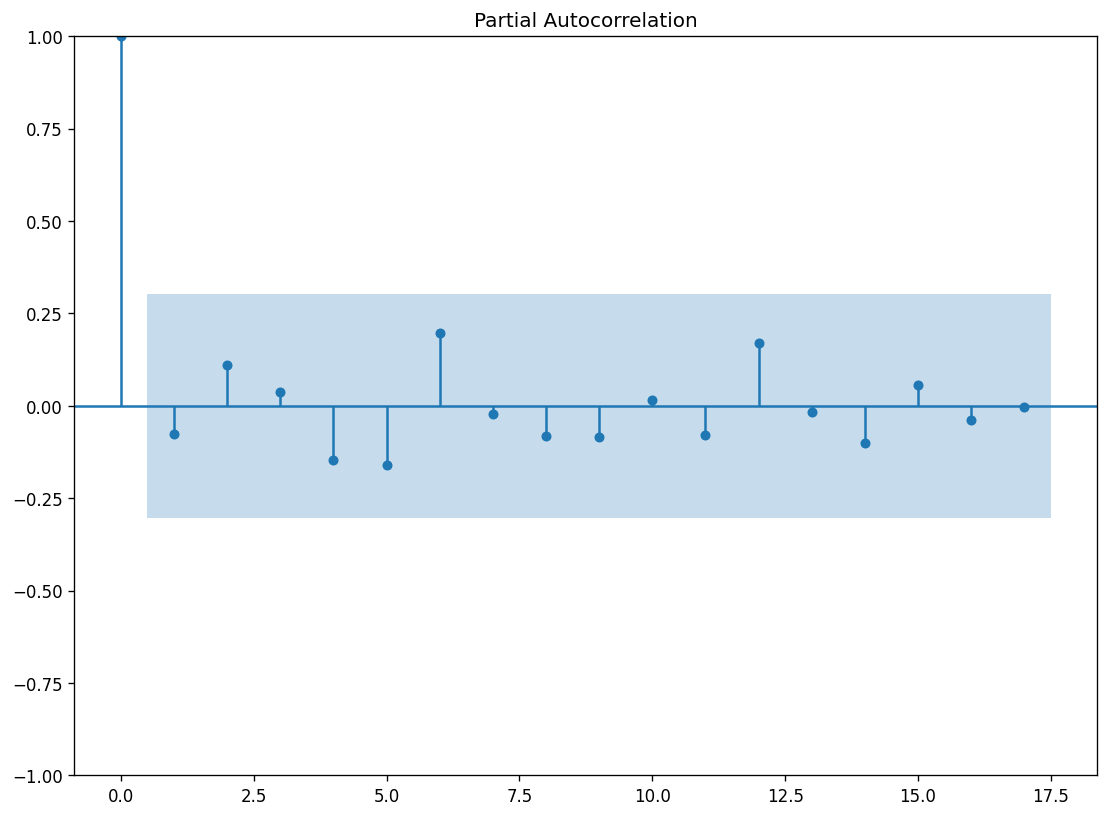

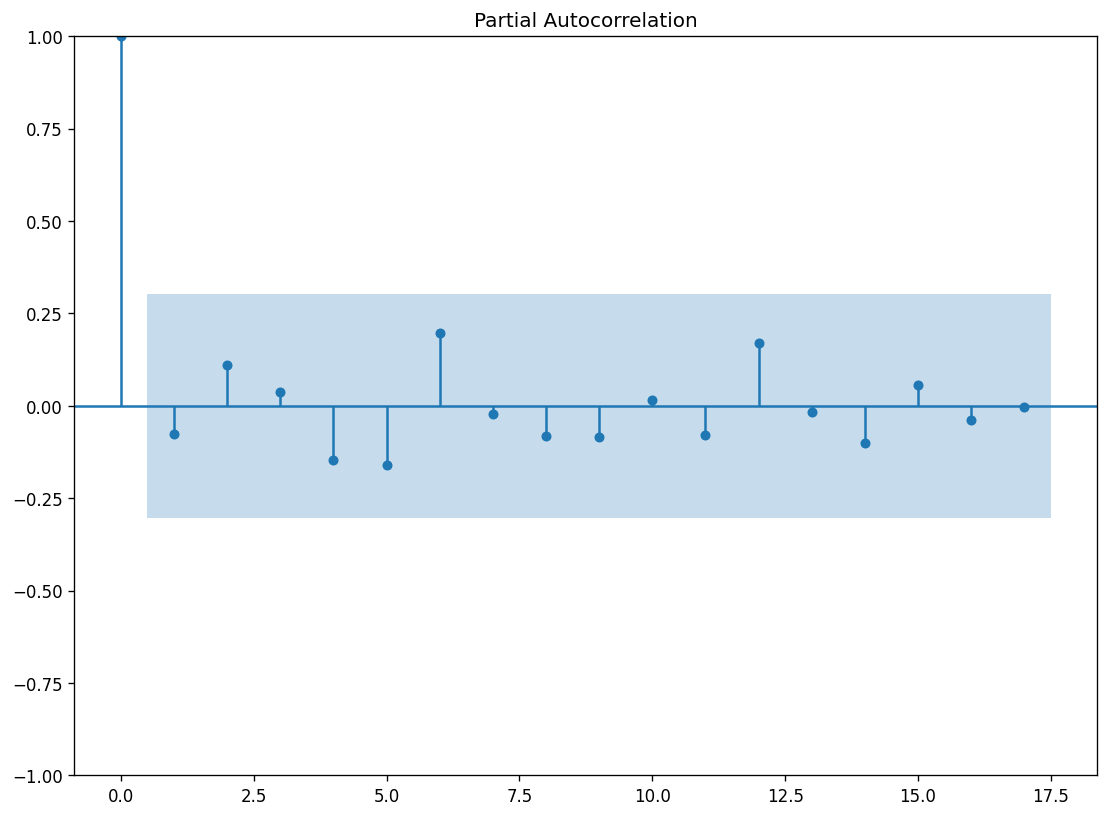

In [112]:
# Finding the value of the p parameter
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(funded_amount_ts.diff().dropna())

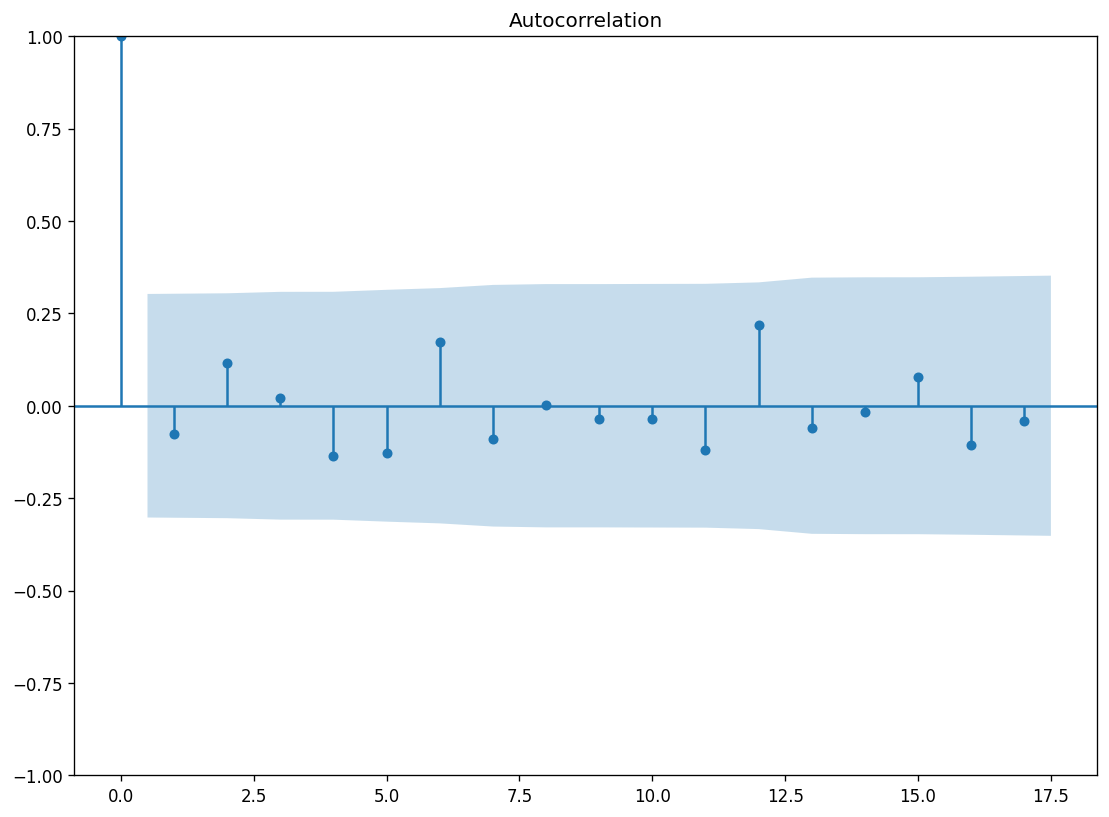

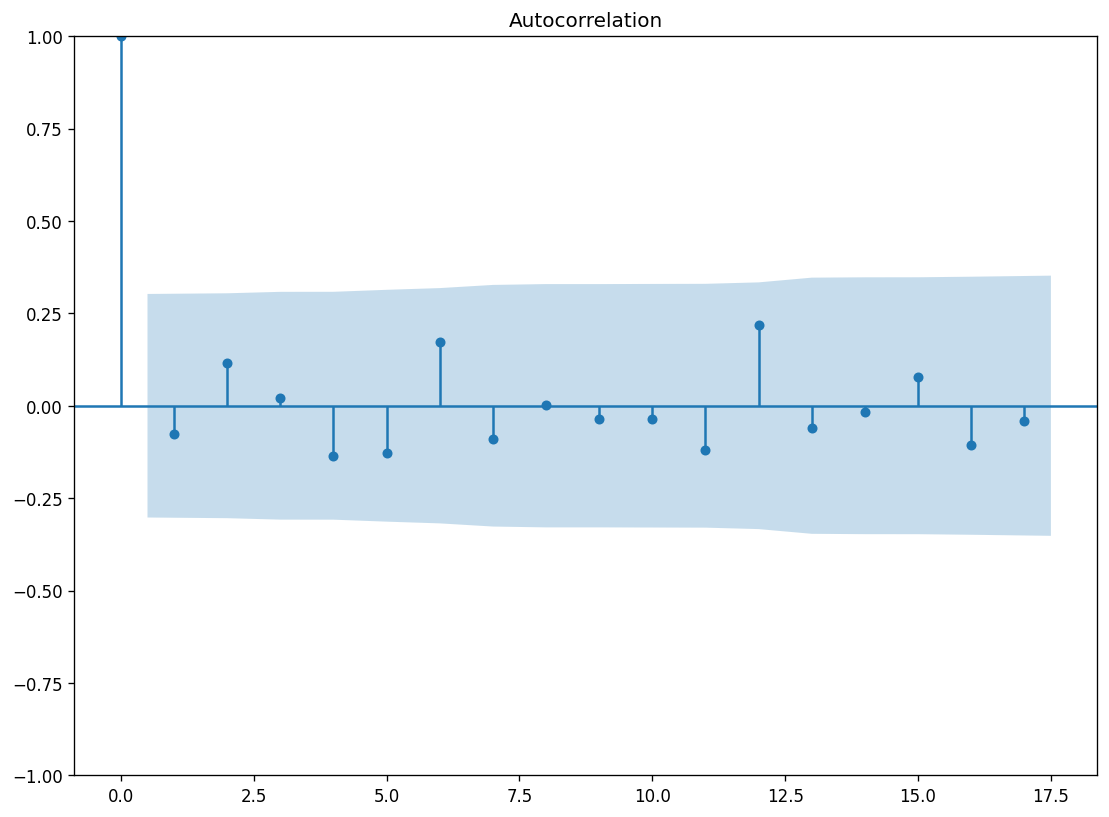

In [113]:
# Finding the value of the q parameter
plot_acf(funded_amount_ts.diff().dropna())

In [114]:
# Step 4: Build the ARIMA model
model = ARIMA(funded_amount_ts, order=(1, 1, 1))
arima_model = model.fit()

C:\Users\PC\AppData\Local\Temp\ipykernel_19000\1215340983.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=funded_amount_ts.index[-1], periods=forecast_steps, freq='M')


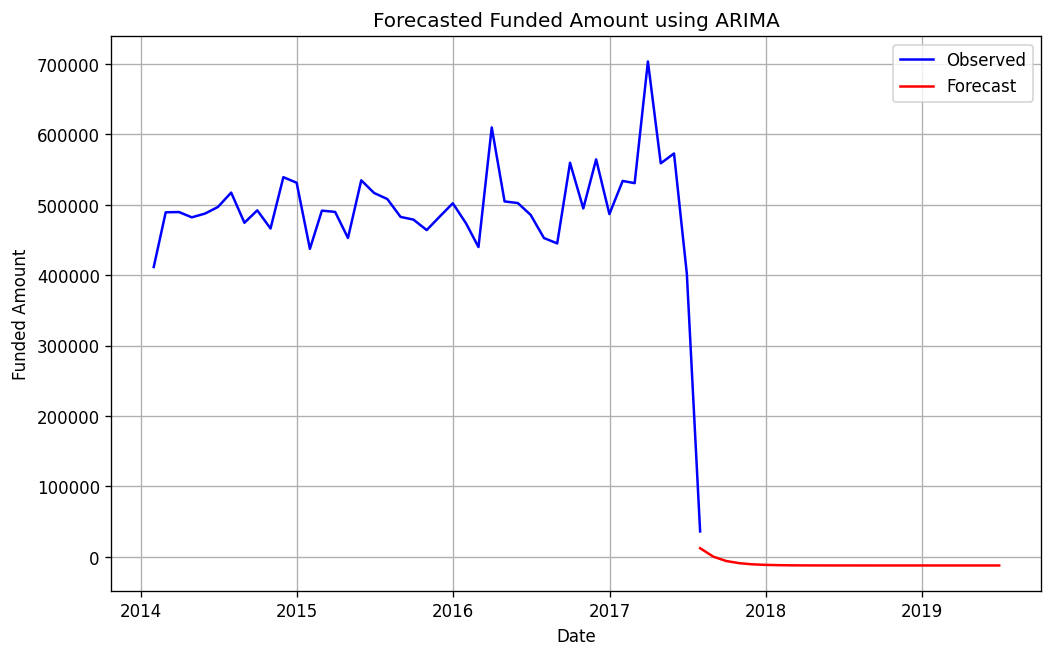

In [115]:

# Step 5: Forecast
forecast_steps = 24  # Adjust as needed
forecast_index = pd.date_range(start=funded_amount_ts.index[-1], periods=forecast_steps, freq='M')
forecast = arima_model.forecast(steps=forecast_steps)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(funded_amount_ts.index, funded_amount_ts, label='Observed', color='blue')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title('Forecasted Funded Amount using ARIMA')
plt.xlabel('Date')
plt.ylabel('Funded Amount')
plt.legend()
plt.grid(True)
plt.show()


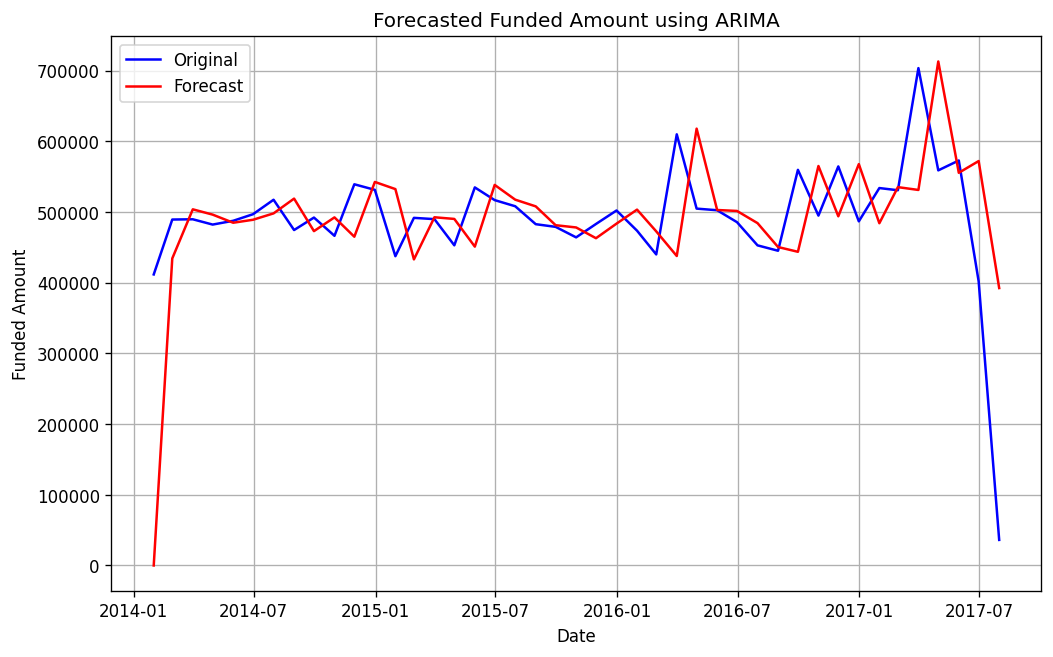

In [116]:
forecast = arima_model.predict(start=funded_amount_ts.index[0], end=funded_amount_ts.index[-1], typ='levels')
# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(funded_amount_ts, label='Original', color='blue')
plt.plot(forecast, label='Forecast', color='red')
plt.title('Forecasted Funded Amount using ARIMA')
plt.xlabel('Date')
plt.ylabel('Funded Amount')
plt.legend()
plt.grid(True)
plt.show()